In [1]:
import json as json
import pandas as pd

## Get the Data

In [2]:
with open("data/icd2pmid.json", 'r') as f:
    Data_pmid =  json.load(f)

In [3]:
heart_pmid = Data_pmid['heart failure']

In [4]:
with open("data/cvddocs.json", 'r') as f:
    Data_title =  json.load(f)

In [5]:
# creating a list with title and pmid
title = []
for item in Data_title:
    #print(item)
    title.append({"pmid": item['pmid'], "title": item['title']})

In [6]:
# converting list to dataframe
title_df = pd.DataFrame(title)
title_df.head()

,pmid,title
0,21240586,[Influence of the demographic change on hospit...
1,23324988,Comparison of stroke mortality in Finnish-born...
2,26748100,Mortality trends in cardiovascular causes in s...
3,3362795,Health care utilization and costs for diseases...
4,8232031,"Australian deaths in custody, 1980-1989. 2. Ca..."


In [7]:
title_df = title_df[title_df['pmid'].isin(heart_pmid)]
title_df = title_df.reset_index(drop=True)
title_df = title_df.drop_duplicates('pmid', keep = False)

In [8]:
title_df.shape

(50976, 2)

In [9]:
title_df.head()

,pmid,title
48470,10694616,Results of revascularization in patients with ...
48471,25746522,Diastolic dysfunction.
48473,3963944,Clinical experience with timolol maleate monot...
48477,29524314,Semaphorin 4D levels in heart failure patients...
48478,12008175,Effects of perindopril on aldosterone producti...


## Data Cleaning

In [10]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [11]:
def clean_text(text):
    #Convert to lower case
    text = text.lower()
    #Lemmatizing the text
    lemma = WordNetLemmatizer()
    normalized = " ".join(lemma.lemmatize(word, pos = "v") for word in text.split())
    #Removing White spaces
    normalized = normalized.replace('\d+', '')
    normalized = normalized.strip()
    #Tokenize and extract words that are alpha-numeric
    tokens = word_tokenize(normalized)
    cleaned = [word for word in tokens if word.isalpha()]
    #Create a dictionary of stem-words such as "at" and 
    #"the" that don't contribute to meaning and remove them from the list
    stop_words = set(stopwords.words('english'))
    words = [w for w in cleaned if not w in stop_words]
    #Remove punctuations
    #exclude = set(string.punctuation)
    #punc_free = [ch for ch in stop_words if ch not in exclude]
    return words

In [12]:
title_df["title"] = [clean_text(text) for text in title_df["title"]]
title_df.head()

,pmid,title
48470,10694616,"[result, revascularization, patients, severe, ..."
48471,25746522,"[diastolic, dysfunction]"
48473,3963944,"[clinical, experience, timolol, maleate, monot..."
48477,29524314,"[semaphorin, level, heart, failure, patients, ..."
48478,12008175,"[effect, perindopril, aldosterone, production,..."


In [13]:
import itertools
from collections import Counter
title_list = itertools.chain(title_df['title'])
title_list = list(title_list)
flattened = [val for sublist in title_list for val in sublist]
counts = Counter(flattened)
df_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_counts.columns = ['word', 'count']
df_counts = df_counts.sort_values(['count'], ascending=[False])
df_counts = df_counts.reset_index(drop=True)
df_counts.head(10)

,word,count
0,heart,30633
1,failure,27044
2,patients,13845
3,cardiac,7206
4,chronic,6328
5,ventricular,5479
6,leave,4384
7,effect,3863
8,study,3848
9,disease,3736


In [14]:
df_counts['rel_freq'] = df_counts['count']/sum(df_counts['count'])

In [15]:
df_counts.head(10)

,word,count,rel_freq
0,heart,30633,0.063753
1,failure,27044,0.056283
2,patients,13845,0.028814
3,cardiac,7206,0.014997
4,chronic,6328,0.013170
5,ventricular,5479,0.011403
6,leave,4384,0.009124
7,effect,3863,0.008040
8,study,3848,0.008008
9,disease,3736,0.007775


## Visualizations - EDA

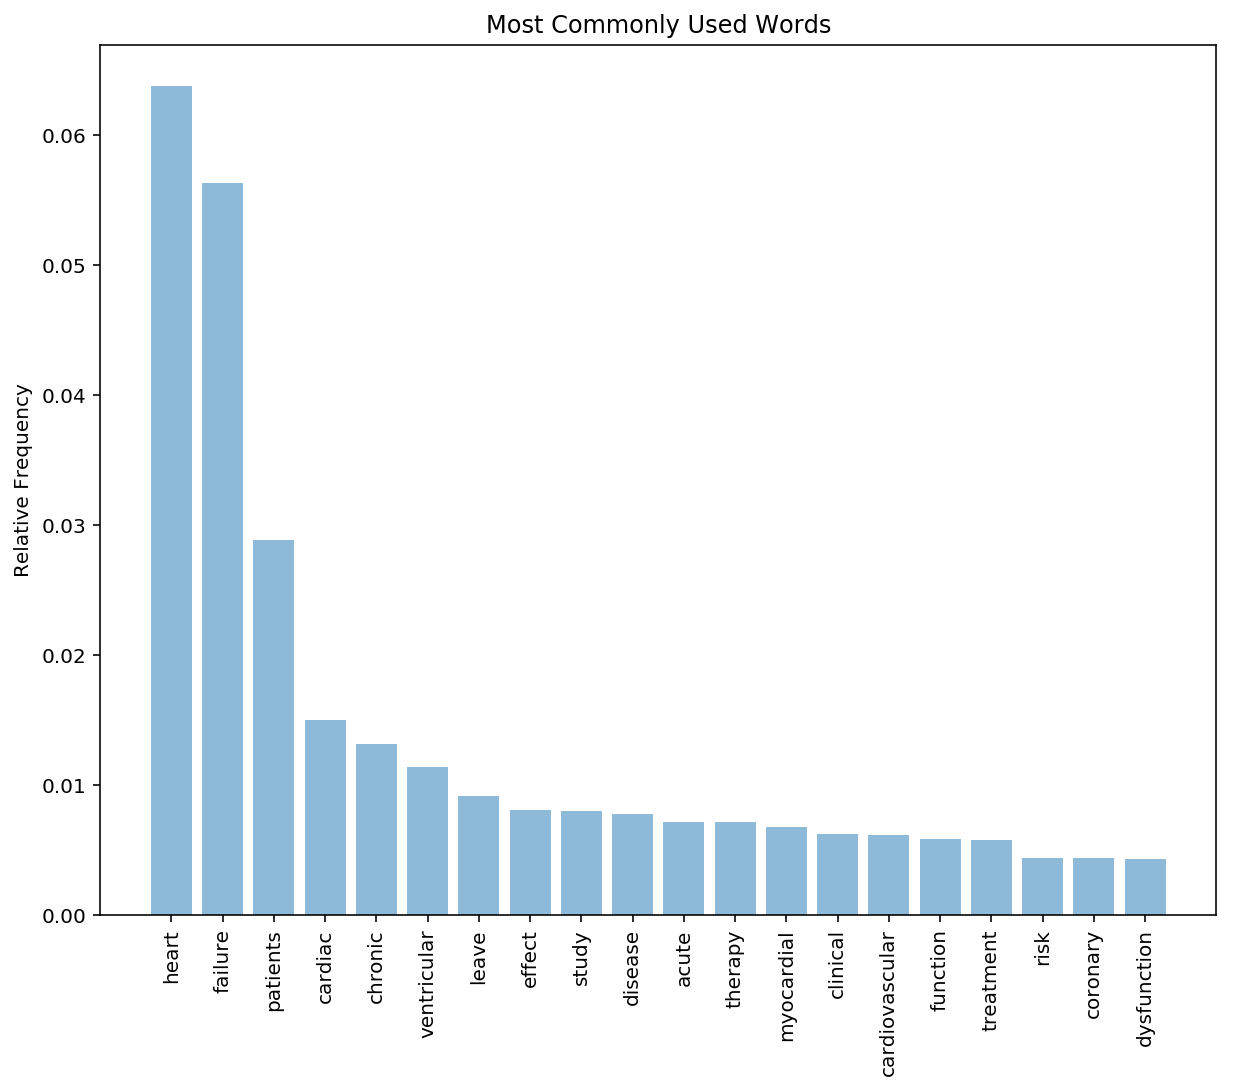

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.bar(df_counts['word'][0:20], df_counts['rel_freq'][0:20], align='center', alpha=0.5)
plt.xticks(df_counts['word'][0:20], rotation = 'vertical')
plt.ylabel('Relative Frequency')
plt.title('Most Commonly Used Words')

plt.show()

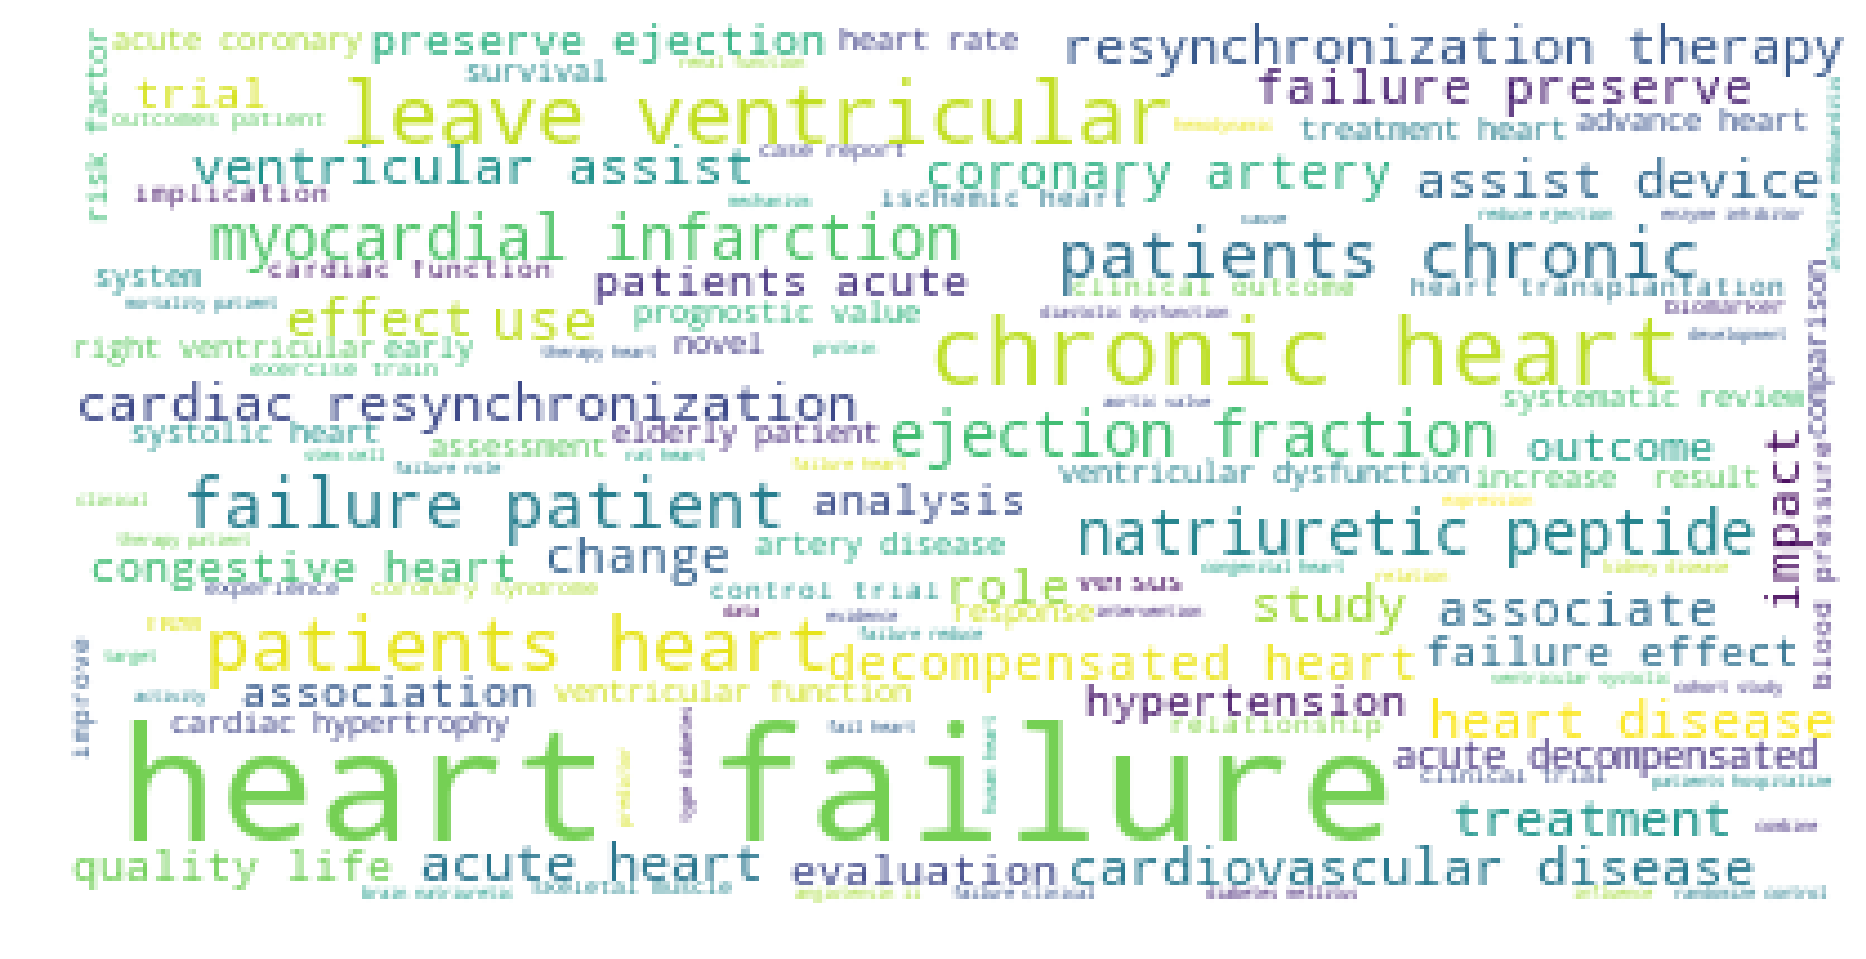

In [21]:
from wordcloud import WordCloud, STOPWORDS

# Combine all reviews for the desired sentiment
combined_text = " ".join([wd for wd in flattened])


# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=200,
        stopwords = STOPWORDS.update(['COMMA','one','other','PERIOD',
                                      'citation','many','two','also','however']))

# Generate and plot wordcloud
plt.figure(figsize =[16,16])
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

## Limiting Title Words

In [16]:
keep_words = df_counts[df_counts['count'] > 100]
keep_words = keep_words['word']
type(keep_words)

pandas.core.series.Series

In [17]:
keep_words = list(keep_words)
keep_words[0:10]

['heart',
 'failure',
 'patients',
 'cardiac',
 'chronic',
 'ventricular',
 'leave',
 'effect',
 'study',
 'disease']

In [18]:
def list_comp(text):
    return [x for x in text if x in keep_words]

title_df["title"] = [list_comp(text) for text in title_df["title"]]

In [19]:
title_df.head(10)

,pmid,title
48470,10694616,"[result, revascularization, patients, severe, ..."
48471,25746522,"[diastolic, dysfunction]"
48473,3963944,"[clinical, experience, hypertension]"
48477,29524314,"[level, heart, failure, patients, potential, n..."
48478,12008175,"[effect, aldosterone, production, fail, human,..."
48480,21080863,"[change, blood, pressure, acute, heart, failur..."
48481,29202359,"[intravenous, administration, rat, chronic, he..."
48486,16555861,"[mechanisms, management, digoxin]"
48490,21140063,"[heart, energy, metabolism, role, treatment, h..."
48491,12385167,"[status, outcomes, disease, management, progra..."


## K-Means

In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import gensim
import sklearn.preprocessing
import nltk
import os,re

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

### TF-IDF

In [46]:
tfidf_vectorizer = TfidfVectorizer(analyzer="word",
                                   tokenizer=nltk.word_tokenize,
                                   preprocessor=None,
                                   stop_words='english',
                                   max_features=None)
sparce_tfidf = tfidf_vectorizer.fit_transform([" ".join(x) for x in title_df['title']])

In [47]:
tfidf = sparce_tfidf.toarray()

In [48]:
from sklearn.decomposition import TruncatedSVD

In [31]:
svd = TruncatedSVD(n_components=100, n_iter=25, random_state=12)
t_tfidf = svd.fit_transform(tfidf)

In [40]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

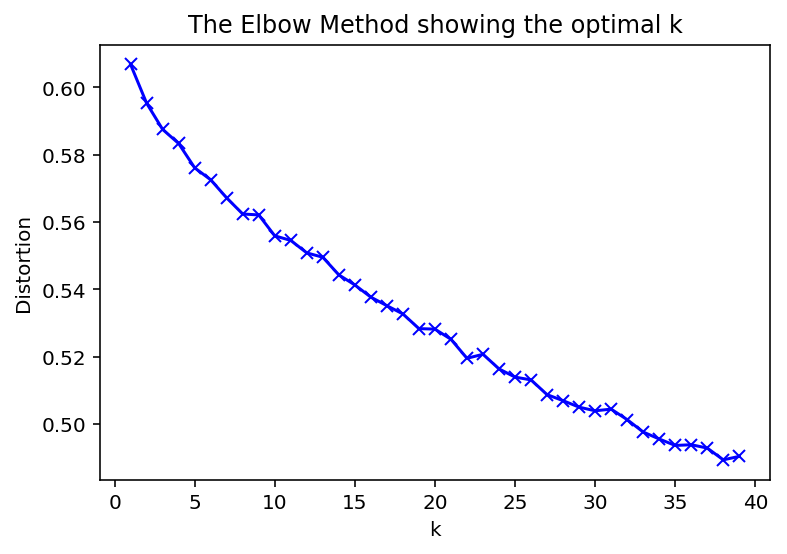

In [33]:
# k means determine k
distortions = []
K = range(1,40)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(t_tfidf)
    kmeanModel.fit(t_tfidf)
    distortions.append(sum(np.min(cdist(t_tfidf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / len(t_tfidf))

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [34]:
title_df['vector_len'] = [len(text) for text in title_df['title']]
title_df.head(100)

,pmid,title,vector_len
48470,10694616,"[result, revascularization, patients, severe, ...",7
48471,25746522,"[diastolic, dysfunction]",2
48473,3963944,"[clinical, experience, hypertension]",3
48477,29524314,"[level, heart, failure, patients, potential, n...",10
48478,12008175,"[effect, aldosterone, production, fail, human,...",6
48480,21080863,"[change, blood, pressure, acute, heart, failur...",8
48481,29202359,"[intravenous, administration, rat, chronic, he...",6
48486,16555861,"[mechanisms, management, digoxin]",3
48490,21140063,"[heart, energy, metabolism, role, treatment, h...",7
48491,12385167,"[status, outcomes, disease, management, progra...",8


### Bag of Words

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
count_vectorizer = CountVectorizer(analyzer="word",
                                   tokenizer=nltk.word_tokenize,
                                   preprocessor= None,
                                   stop_words='english',
                                   max_features=None)  
bag_of_words = count_vectorizer.fit_transform([" ".join(x) for x in title_df['title']])

In [37]:
bow = bag_of_words.toarray()
bow[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
from sklearn.decomposition import TruncatedSVD

In [39]:
svd = TruncatedSVD(n_components=100, n_iter=25, random_state=12)
t_bow = svd.fit_transform(bag_of_words)

In [40]:
t_bow

array([[ 4.34988231e-01,  1.57046141e+00,  1.97183748e-01, ...,
         8.91877860e-02,  5.53400366e-02, -1.84244099e-02],
       [ 3.92601895e-02,  1.51540552e-01,  1.16543671e-01, ...,
         2.59308716e-02,  2.29066324e-02,  1.10841891e-02],
       [ 5.21668297e-02,  6.37833812e-02, -1.63830808e-02, ...,
        -1.97775286e-02,  3.21888245e-03, -2.42009730e-02],
       ...,
       [ 2.93931424e-02, -1.89356849e-03, -2.45693763e-02, ...,
         3.57517425e-02, -1.73515105e-02,  1.59126824e-03],
       [ 5.81265827e-02,  1.25563942e-01,  1.01710904e-01, ...,
        -1.00766596e-01, -5.17463438e-02,  3.94066076e-02],
       [ 1.65156609e+00,  2.50406069e-01, -4.40028908e-01, ...,
         4.59663132e-02, -5.13421074e-02,  3.20704019e-01]])

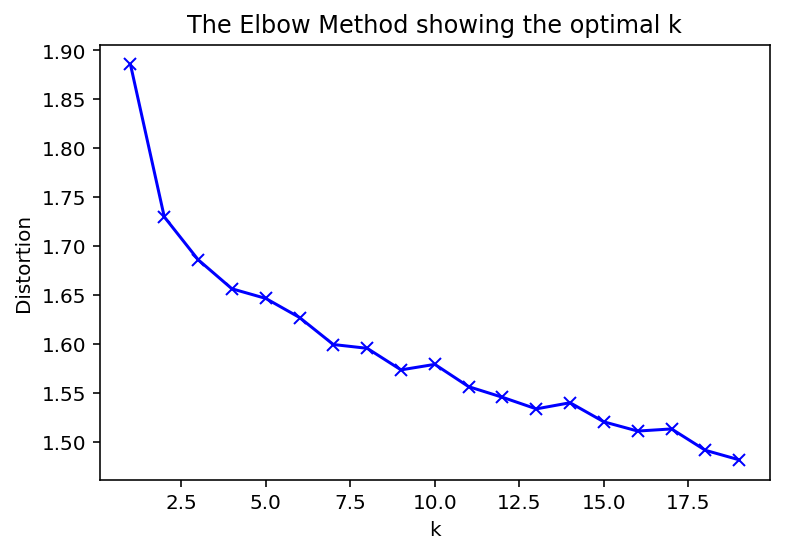

In [41]:
# k means determine k
distortions = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(t_bow)
    kmeanModel.fit(t_bow)
    distortions.append(sum(np.min(cdist(t_bow, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / len(t_bow))

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [42]:
true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(t_bow)

print("Top terms per cluster:")

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 active
 abnormalities
 activation
 abnormal
 administration
 acid
 admission
 ace
 affect
 adult
Cluster 1:
 abnormal
 activity
 activation
 adrenergic
 acute
 adult
 affect
 adults
 aerobic
 antagonists
Cluster 2:
 abnormalities
 abnormal
 age
 acute
 activation
 admit
 adaptive
 alterations
 american
 alter
Cluster 3:
 abnormal
 affect
 american
 anemia
 age
 alter
 acute
 aldosterone
 activation
 analysis
Cluster 4:
 abnormal
 ace
 acid
 adaptive
 activation
 advance
 active
 agents
 administration
 admission
Cluster 5:
 acid
 abnormalities
 abnormal
 ace
 adherence
 admit
 adult
 arteries
 american
 alter
Cluster 6:
 abnormalities
 abnormal
 ace
 aerobic
 adherence
 anemia
 advance
 action
 antagonist
 atrioventricular
Cluster 7:
 activation
 abnormal
 abnormalities
 action
 admission
 adaptive
 administration
 affect
 agents
 adverse
Cluster 8:
 abnormalities
 ace
 abnormal
 analysis
 affect
 acute
 adverse
 american
 alterations
 amyloidosis
Clu

In [43]:
title_df['cluster'] = model.fit_predict(t_bow)
title_df.head(10)

,pmid,title,vector_len,cluster
48470,10694616,"[result, revascularization, patients, severe, ...",7,5
48471,25746522,"[diastolic, dysfunction]",2,1
48473,3963944,"[clinical, experience, hypertension]",3,1
48477,29524314,"[level, heart, failure, patients, potential, n...",10,3
48478,12008175,"[effect, aldosterone, production, fail, human,...",6,8
48480,21080863,"[change, blood, pressure, acute, heart, failur...",8,3
48481,29202359,"[intravenous, administration, rat, chronic, he...",6,2
48486,16555861,"[mechanisms, management, digoxin]",3,1
48490,21140063,"[heart, energy, metabolism, role, treatment, h...",7,3
48491,12385167,"[status, outcomes, disease, management, progra...",8,3


## t-SNE

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [45]:
sns.set(font_scale=1.8)

In [46]:
from sklearn.manifold import TSNE

In [47]:
clrs = []
for row,cluster in title_df[['cluster']].T.iteritems():
    val = np.array(cluster)
    #cluster = max(val)
    for item in val:
        if  item == 0:
            grp =  'navy'
        elif item == 1:
            grp =  'green'
        elif item == 2:
            grp = 'firebrick'
        elif item == 3:
            grp = 'mediumslateblue'
        elif item == 4:
            grp = 'darkgoldenrod'
        elif item == 5:
            grp = 'deepskyblue'
        elif item == 6:
            grp = 'red'
        elif item == 7:
            grp = 'yellowgreen'
        elif item == 8:
            grp = 'yellow'
        elif item == 9:
            grp = 'violet'
    clrs.append(grp)

In [48]:
data = np.array(t_bow)
Xtsne2d = TSNE(n_components=2).fit_transform(data)
Xtsne2d.shape

(50976, 2)

In [49]:
x_min, x_max = np.min(Xtsne2d, axis=0), np.max(Xtsne2d, axis=0)
Xtsne2d = (Xtsne2d - x_min) / (x_max - x_min)

In [50]:
Xtsne2d[0:5]

array([[0.4221259 , 0.43704247],
       [0.48967832, 0.31417722],
       [0.41808346, 0.18867008],
       [0.3750132 , 0.69581515],
       [0.80668616, 0.45970827]], dtype=float32)

In [51]:
PN = Xtsne2d.shape[0]

In [52]:
X2d =[]
Y2d = []
for i in range(PN):
    X2d.append(Xtsne2d[i][0])
    Y2d.append(Xtsne2d[i][1])

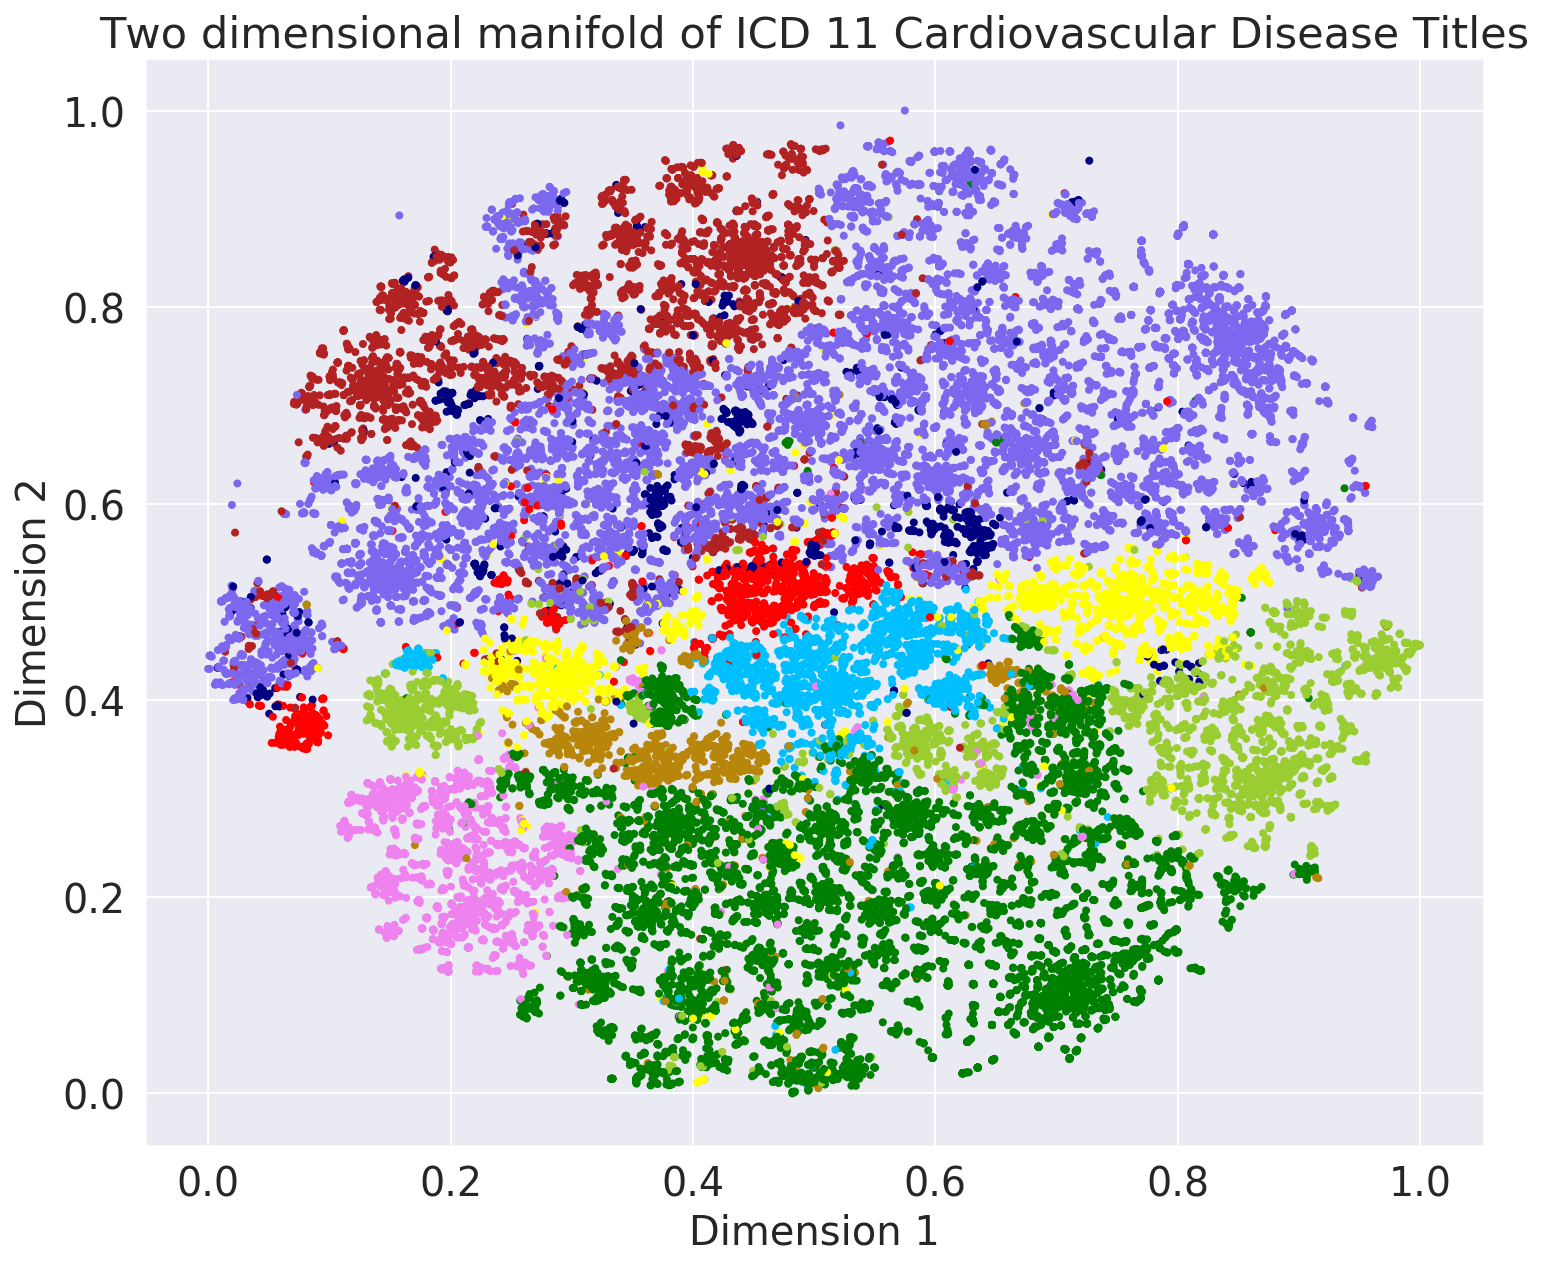

In [56]:
plt.figure(figsize = [12,10])
plt.grid(True)
#plt.axhline(y=0, color='k')
#plt.axvline(x=0, color='k')
plt.title('Two dimensional manifold of ICD 11 Cardiovascular Disease Titles')
plt.xlabel("Dimension 1", fontsize=20)
plt.ylabel("Dimension 2", fontsize=20)
plt.scatter(X2d,Y2d,color = clrs, marker ='.')
plt.savefig('tSNE2d.pdf')

### Word2Vec

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
#import scikitplot.plotters as skplt
import nltk
from collections import Counter
import time
import tensorflow as tf
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
import seaborn as sns
from sklearn.manifold import TSNE
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import random

In [21]:
from w2vec_helper import preprocess,token_lookup,create_lookup_tables

In [63]:
all_txt = " ".join([wd for wd in flattened])
            
words = preprocess(all_txt)
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))
print(words[:30])

Total words: 461420
Unique words: 4692
['result', 'revascularization', 'patients', 'severe', 'leave', 'ventricular', 'dysfunction', 'diastolic', 'dysfunction', 'clinical', 'experience', 'monotherapy', 'hypertension', 'level', 'heart', 'failure', 'patients', 'potential', 'novel', 'biomarker', 'acute', 'heart', 'failure', 'effect', 'perindopril', 'aldosterone', 'production', 'fail', 'human', 'heart']


In [23]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [24]:
from collections import Counter

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [25]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [26]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [27]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

In [28]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [29]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [30]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [31]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [32]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
                
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 2/10 Iteration: 100 Avg. Training loss: 4.9455 0.0254 sec/batch
Epoch 4/10 Iteration: 200 Avg. Training loss: 4.8465 0.0015 sec/batch
Epoch 5/10 Iteration: 300 Avg. Training loss: 4.7678 0.0267 sec/batch
Epoch 7/10 Iteration: 400 Avg. Training loss: 4.6887 0.0030 sec/batch
Epoch 8/10 Iteration: 500 Avg. Training loss: 4.6064 0.0282 sec/batch
Epoch 10/10 Iteration: 600 Avg. Training loss: 4.5197 0.0045 sec/batch


In [33]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


In [34]:
print(embed_mat)

[[-0.28870416 -0.30772    -0.5213604  ...  0.7393318   0.349181
  -0.18166731]
 [ 0.24845964  0.7389815  -0.06091303 ... -0.56594455 -0.09315675
   0.35230207]
 [ 0.5797915  -0.8486175  -0.17892021 ...  0.21217799  0.17977706
   0.68193984]
 ...
 [ 0.43554106 -0.14295346 -1.0076412  ... -0.24599576  0.04074582
  -0.25187096]
 [-0.32507014  0.15053187  0.2975768  ... -0.09762067 -0.29312027
  -0.23508827]
 [-0.5403386  -0.7545825   0.04631088 ...  0.30670863 -0.00490921
   0.14782883]]


In [57]:
embed_mat[0].shape

(200,)

In [35]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

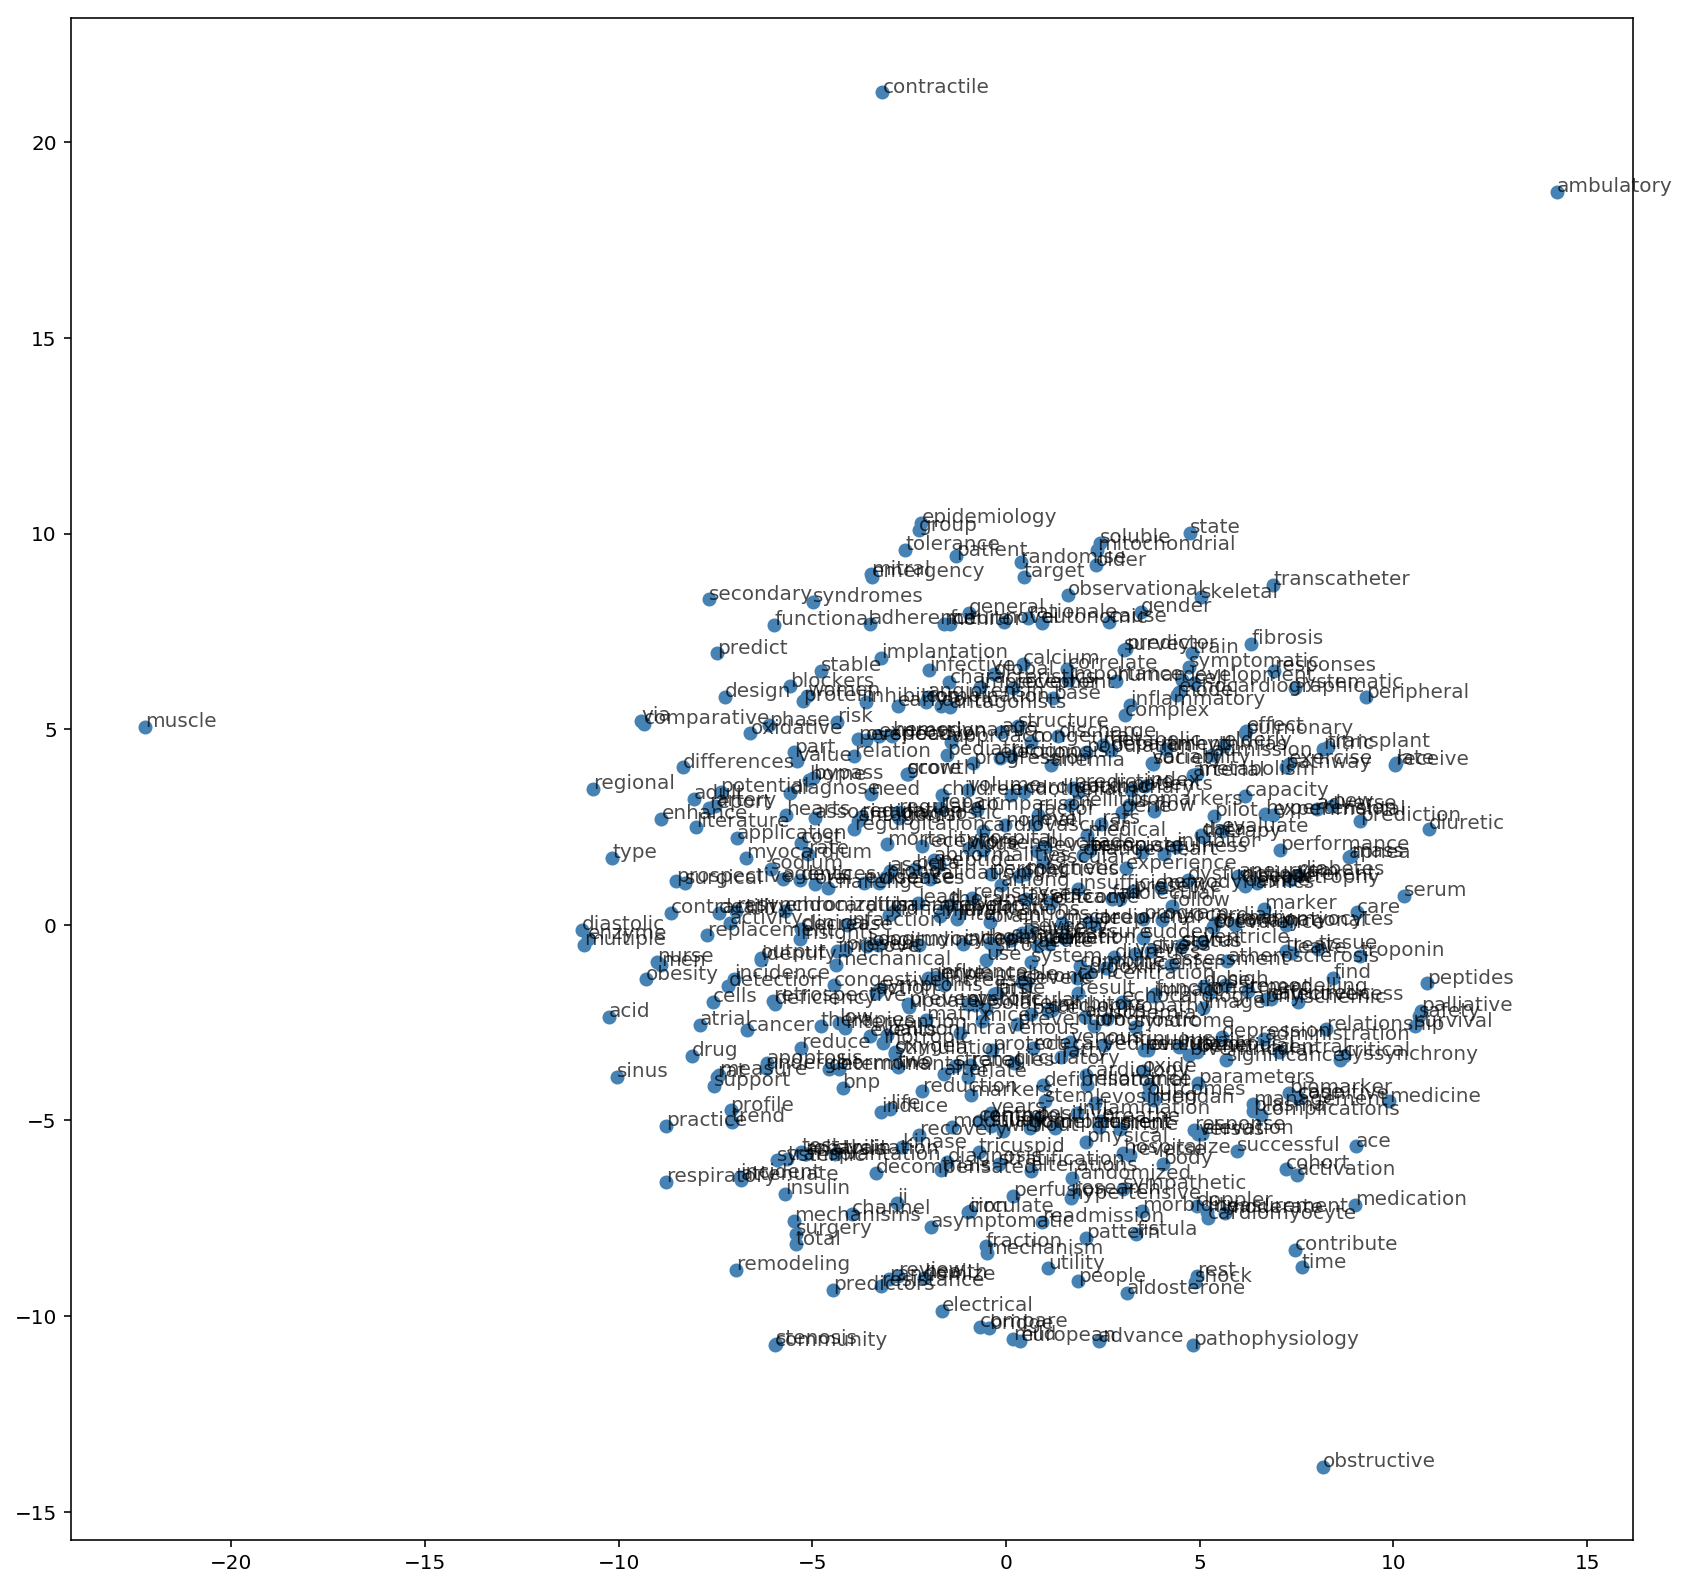

In [36]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

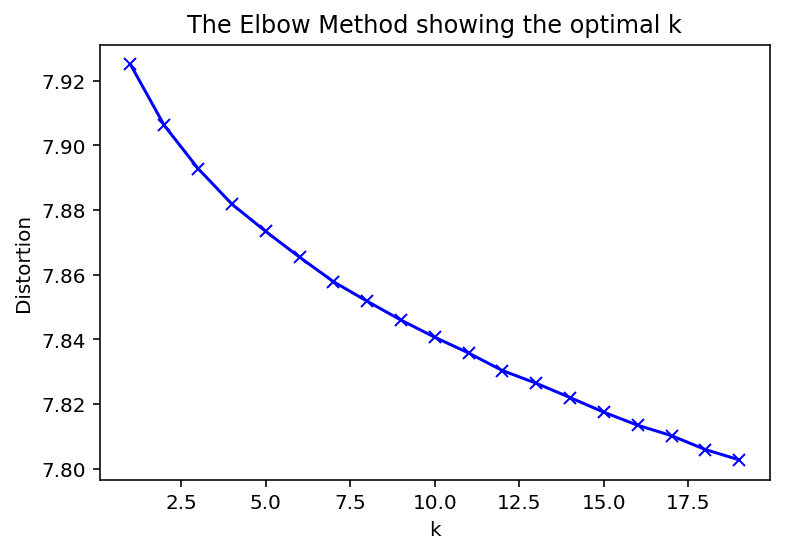

In [41]:
# k means determine k
distortions = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(embed_mat)
    kmeanModel.fit(embed_mat)
    distortions.append(sum(np.min(cdist(embed_mat, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / len(embed_mat))

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [49]:
true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(embed_mat)

print("Top terms per cluster:")

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 adrenergic
 determine
 change
 adherence
 congenital
 affect
 circulation
 adults
 cells
 coronary
Cluster 1:
 arterial
 dilate
 brain
 asymptomatic
 benefit
 apoptosis
 cachexia
 author
 adrenergic
 congenital
Cluster 2:
 defect
 acute
 cardiology
 asymptomatic
 dietary
 cardiogenic
 circulatory
 biomarker
 cognitive
 c
Cluster 3:
 cognitive
 design
 body
 action
 congenital
 detection
 baseline
 beneficial
 biventricular
 alterations
Cluster 4:
 cancer
 deficiency
 channel
 arterial
 correlate
 discharge
 clinical
 apnea
 cardiomyopathy
 diagnostic
Cluster 5:
 apnea
 channel
 adults
 contractile
 alter
 beneficial
 bnp
 acute
 differential
 blockade
Cluster 6:
 compare
 damage
 design
 associate
 determine
 correlate
 circulatory
 administration
 approach
 congenital
Cluster 7:
 cost
 correlate
 cognitive
 antagonists
 assessment
 cardiogenic
 course
 apnea
 delay
 baseline
Cluster 8:
 deficiency
 adults
 apnea
 adherence
 clinic
 bnp
 blockers
 dep

## t-SNE for Word2Vec

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [72]:
w = set(words)
words_df = pd.DataFrame(list(w), columns=['words']) 
words_df.head()

,words
0,health
1,von
2,scale
3,coenzyme
4,qualify


In [74]:
words_df['cluster'] = model.fit_predict(embed_mat)

In [75]:
sns.set(font_scale = 1.8)

In [76]:
from sklearn.manifold import TSNE

In [77]:
clrs = []
for row,cluster in words_df[['cluster']].T.iteritems():
    val = np.array(cluster)
    #cluster = max(val)
    for item in val:
        if  item == 0:
            grp =  'navy'
        elif item == 1:
            grp =  'green'
        elif item == 2:
            grp = 'firebrick'
        elif item == 3:
            grp = 'mediumslateblue'
        elif item == 4:
            grp = 'darkgoldenrod'
        elif item == 5:
            grp = 'deepskyblue'
        elif item == 6:
            grp = 'red'
        elif item == 7:
            grp = 'yellowgreen'
        elif item == 8:
            grp = 'yellow'
        elif item == 9:
            grp = 'violet'
    clrs.append(grp)

In [78]:
data = np.array(embed_mat)
Xtsne2d = TSNE(n_components=2).fit_transform(data)
Xtsne2d.shape

(4692, 2)

In [79]:
x_min, x_max = np.min(Xtsne2d, axis=0), np.max(Xtsne2d, axis=0)
Xtsne2d = (Xtsne2d - x_min) / (x_max - x_min)

In [80]:
Xtsne2d[0:5]

array([[0.369211  , 0.2726673 ],
       [0.47223514, 0.374619  ],
       [0.54031765, 0.30044985],
       [0.5830302 , 0.14008296],
       [0.35837662, 0.25487942]], dtype=float32)

In [81]:
PN = Xtsne2d.shape[0]

In [82]:
X2d =[]
Y2d = []
for i in range(PN):
    X2d.append(Xtsne2d[i][0])
    Y2d.append(Xtsne2d[i][1])

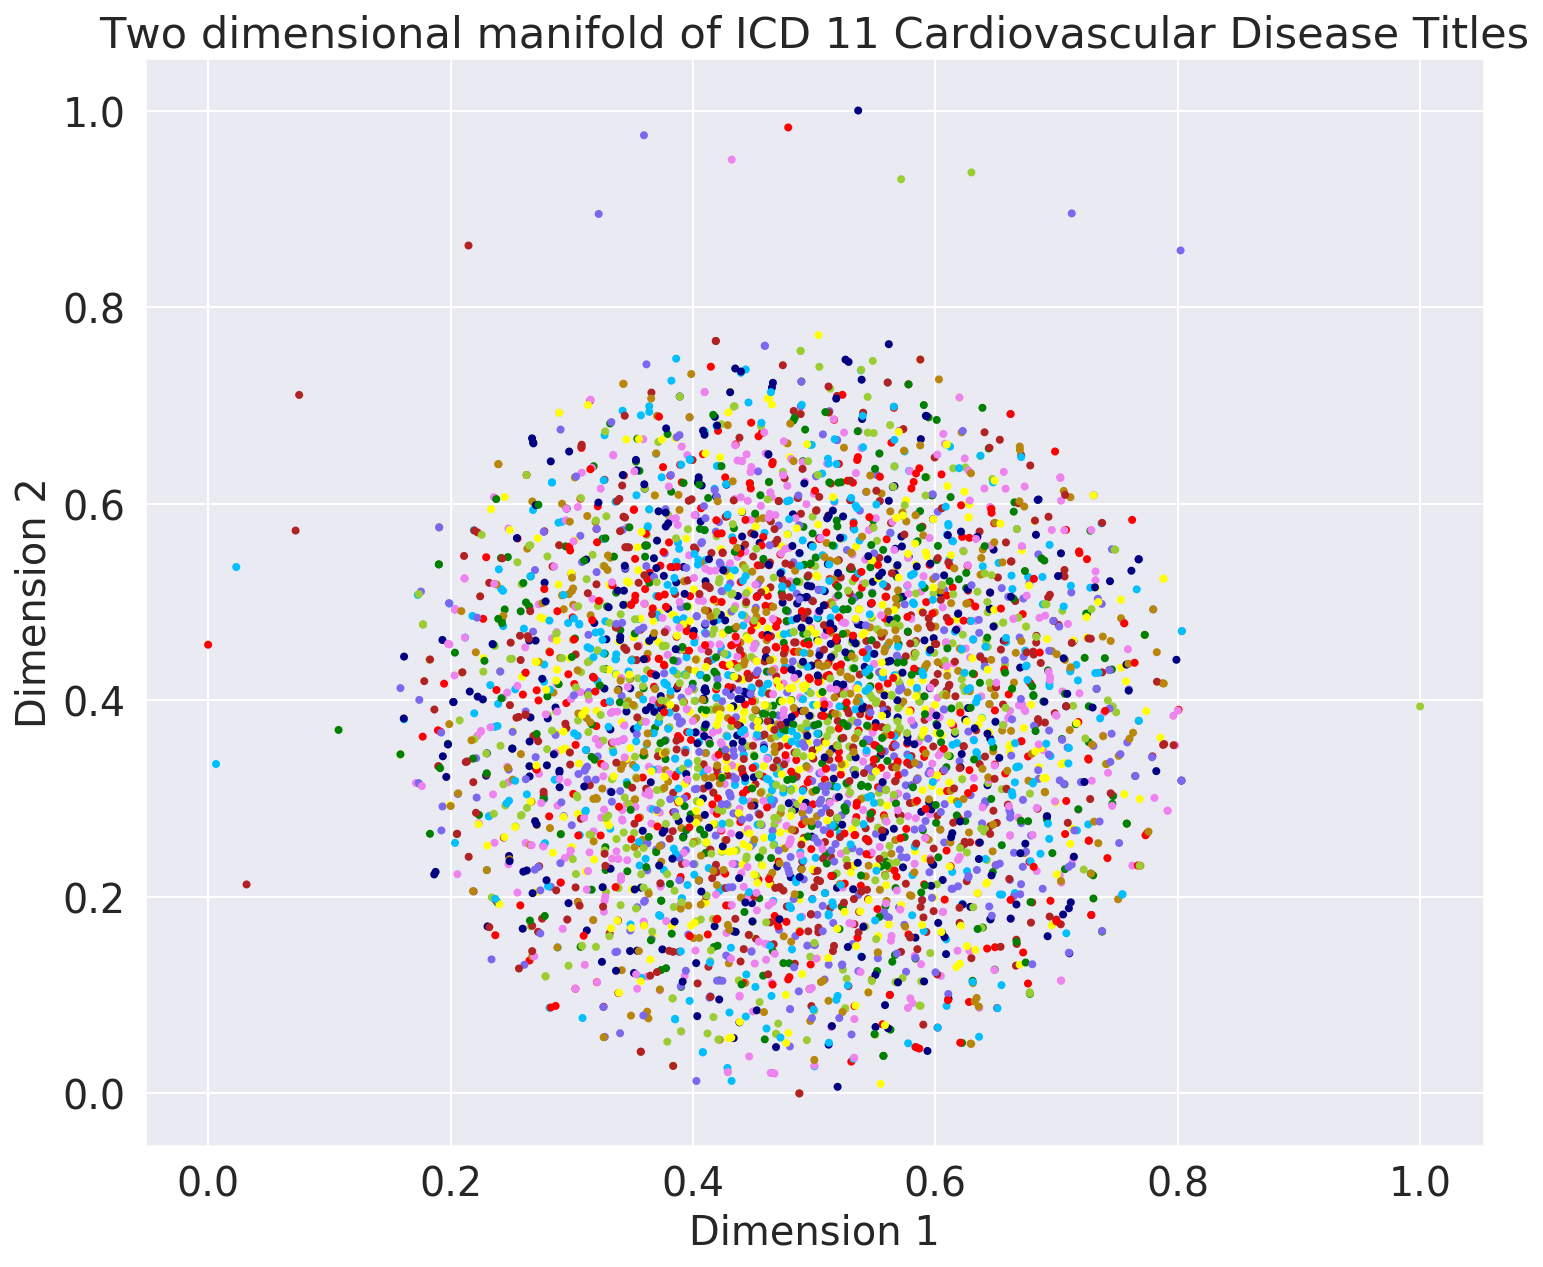

In [83]:
plt.figure(figsize = [12,10])
plt.grid(True)
#plt.axhline(y=0, color='k')
#plt.axvline(x=0, color='k')
plt.title('Two dimensional manifold of ICD 11 Cardiovascular Disease Titles')
plt.xlabel("Dimension 1", fontsize=20)
plt.ylabel("Dimension 2", fontsize=20)
plt.scatter(X2d,Y2d,color = clrs, marker ='.')
#plt.savefig('tSNE2d.pdf')